In [1]:
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [2]:
import sklearn
from tsai.basics import *
my_setup(sklearn)

os              : Linux-6.2.0-35-generic-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.7
fastai          : 2.7.12
fastcore        : 1.5.29
sklearn         : 1.2.2
torch           : 1.13.1+cu117
cpu cores       : 14
threads per cpu : 1
RAM             : 31.17 GB
GPU memory      : N/A


/home/kiwoongyoon/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
import random
import os
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [30]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [60]:
train = pd.read_csv('../../DATA/train.csv')
test  = pd.read_csv('../../DATA/test.csv')

In [61]:

new_column_names = {
    'corporation': 'corp',
    'location': 'loc',
    'supply(kg)': 'supply',
    'price(원/kg)': 'price',
}

train = train.rename(columns=new_column_names)
test = test.rename(columns=new_column_names)

train['timestamp']  = pd.to_datetime(train['timestamp'])
test['timestamp']  = pd.to_datetime(test['timestamp'])

train['newitem'] = train['item'].str.cat([train['corp'], train['loc']], sep=' ')

In [62]:
#가격 시계열 price_data 생성하기 

def before_timeseries_data(train):
    unique_values = train['newitem'].unique()
    # 날짜 범위 생성
    start_date = datetime(2019, 1, 1).date()
    end_date =datetime(2023, 3, 3).date()
    dates = pd.date_range(start_date, end_date, freq='D')

    # 데이터프레임 생성
    price_data = pd.DataFrame(columns=['item'] + dates.strftime('%Y-%m-%d').tolist())
    price_data['item'] = unique_values

    # print(len(price_data)) 39 
    for i in range(len(price_data)) :
        price_data.iloc[i,1:] = train['price'][i*1523 : (i+1)*1523 ]
    price_data['item'] = price_data['item'].astype(str)
    price_data['corp'] = price_data['item'].str[3:4]

    price_data['loca'] = price_data['item'].str[-1:]
    price_data['product'] = price_data['item'].str[:2]
    price_data['product_loca'] =price_data['product'].str.cat(price_data['loca'], sep=' ')
    cols = price_data.columns[-4:]  # 가장 뒤의 3개 열의 열 이름을 선택
    price_data = price_data[cols.tolist() + price_data.columns[:-4].tolist()]  # 열 순서 변경
    
    return price_data

price_data = before_timeseries_data(train)

In [63]:
price_data = price_data.drop(columns=['corp', 'loca','product','product_loca','item'])
price_data

,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,...,2023-02-22,2023-02-23,2023-02-24,2023-02-25,2023-02-26,2023-02-27,2023-02-28,2023-03-01,2023-03-02,2023-03-03
0,0.0,0.0,1728.0,1408.0,1250.0,0.0,1474.0,1326.0,1428.0,1433.0,...,2813.0,2770.0,2633.0,3155.0,0.0,2657.0,3922.0,3397.0,3195.0,3640.0
1,0.0,0.0,2526.0,2134.0,2075.0,0.0,2181.0,2029.0,1998.0,2023.0,...,3444.0,3481.0,3518.0,4201.0,0.0,4166.0,4009.0,4173.0,4219.0,4089.0
2,0.0,0.0,1692.0,1516.0,1471.0,0.0,1508.0,1350.0,1340.0,1211.0,...,4175.0,6216.0,3558.0,2412.0,0.0,3540.0,3141.0,6382.0,3558.0,3470.0
3,0.0,0.0,1944.0,1815.0,1717.0,0.0,1858.0,1660.0,1564.0,1631.0,...,3202.0,3478.0,3939.0,3677.0,0.0,4057.0,3821.0,4037.0,4004.0,4241.0
4,0.0,0.0,1965.0,1794.0,1773.0,0.0,1582.0,1604.0,1633.0,1684.0,...,4017.0,4585.0,4835.0,5550.0,0.0,5037.0,2643.0,3742.0,3983.0,5175.0
5,0.0,0.0,2078.0,2002.0,1815.0,0.0,1905.0,1676.0,1802.0,1724.0,...,3228.0,3484.0,3773.0,4298.0,0.0,4180.0,4234.0,4357.0,4466.0,4748.0
6,0.0,0.0,1616.0,1337.0,1234.0,0.0,1319.0,1499.0,1412.0,1356.0,...,0.0,0.0,1838.0,1829.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,2048.0,1757.0,1719.0,0.0,1814.0,1740.0,1710.0,1618.0,...,2539.0,2955.0,3323.0,3321.0,0.0,3409.0,3236.0,4631.0,4114.0,4146.0
8,0.0,0.0,1692.0,1475.0,1392.0,0.0,1367.0,1352.0,1272.0,1434.0,...,3157.0,4793.0,2403.0,1489.0,0.0,2620.0,1673.0,0.0,1904.0,1622.0
9,0.0,0.0,2151.0,1829.0,2002.0,0.0,1988.0,1856.0,1819.0,2066.0,...,3400.0,3349.0,3026.0,2946.0,0.0,3418.0,3141.0,4235.0,3960.0,3791.0


In [64]:
# price_data = price_data.T
# price_data['date']= price_data.index
# price_data.reset_index(drop= True , inplace = True)
# price_data = price_data[['date'] + [col for col in price_data.columns if col != 'date']]
# price_data
price_data = price_data.T 
price_data['date'] = price_data.index 
price_data.reset_index(drop= True , inplace = True)
price_data = price_data[['date'] + [col for col in price_data.columns if col != 'date']]
price_data

,date,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,2019-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-03,1728.0,2526.0,1692.0,1944.0,1965.0,2078.0,1616.0,2048.0,1692.0,...,2188.0,2440.0,0.0,2079.0,0.0,2253.0,2379.0,0.0,478.0,395.0
3,2019-01-04,1408.0,2134.0,1516.0,1815.0,1794.0,2002.0,1337.0,1757.0,1475.0,...,2455.0,2348.0,0.0,2020.0,0.0,2175.0,2257.0,2301.0,600.0,437.0
4,2019-01-05,1250.0,2075.0,1471.0,1717.0,1773.0,1815.0,1234.0,1719.0,1392.0,...,2242.0,2100.0,0.0,1849.0,1625.0,1981.0,1857.0,1880.0,536.0,425.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,2023-02-27,2657.0,4166.0,3540.0,4057.0,5037.0,4180.0,0.0,3409.0,2620.0,...,2378.0,2610.0,0.0,1859.0,0.0,2473.0,2492.0,2488.0,652.0,468.0
1519,2023-02-28,3922.0,4009.0,3141.0,3821.0,2643.0,4234.0,0.0,3236.0,1673.0,...,3218.0,3035.0,0.0,2873.0,0.0,2896.0,3480.0,3232.0,672.0,531.0
1520,2023-03-01,3397.0,4173.0,6382.0,4037.0,3742.0,4357.0,0.0,4631.0,0.0,...,3838.0,3323.0,0.0,2839.0,0.0,3487.0,3793.0,3816.0,621.0,574.0
1521,2023-03-02,3195.0,4219.0,3558.0,4004.0,3983.0,4466.0,0.0,4114.0,1904.0,...,3067.0,2685.0,0.0,2070.0,0.0,3185.0,3144.0,3321.0,653.0,523.0


In [70]:
# 첫 번째 열을 날짜형으로 변환
price_data.iloc[:, 0] = pd.to_datetime(price_data.iloc[:, 0])

# 나머지 열들을 실수형으로 변환
for col in price_data.columns[1:]:
    price_data[col] = pd.to_numeric(price_data[col], errors='coerce')

price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1523 non-null   object 
 1   0       1523 non-null   float64
 2   1       1523 non-null   float64
 3   2       1523 non-null   float64
 4   3       1523 non-null   float64
 5   4       1523 non-null   float64
 6   5       1523 non-null   float64
 7   6       1523 non-null   float64
 8   7       1523 non-null   float64
 9   8       1523 non-null   float64
 10  9       1523 non-null   float64
 11  10      1523 non-null   float64
 12  11      1523 non-null   float64
 13  12      1523 non-null   float64
 14  13      1523 non-null   float64
 15  14      1523 non-null   float64
 16  15      1523 non-null   float64
 17  16      1523 non-null   float64
 18  17      1523 non-null   float64
 19  18      1523 non-null   float64
 20  19      1523 non-null   float64
 21  20      1523 non-null   float64
 22  

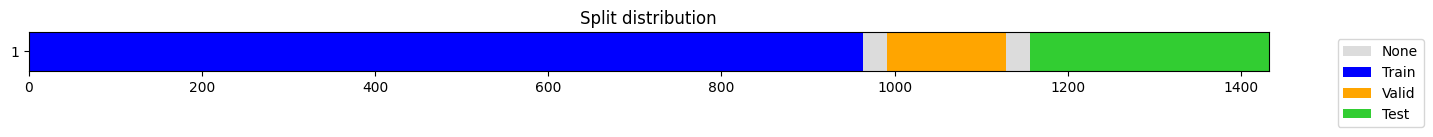

((#964) [0,1,2,3,4,5,6,7,8,9...],
 (#138) [991,992,993,994,995,996,997,998,999,1000...],
 (#276) [1156,1157,1158,1159,1160,1161,1162,1163,1164,1165...])

In [71]:
fcst_history = 64 # # steps in the past
fcst_horizon = 28  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set
datetime_col = 'date'
splits = get_forecasting_splits(price_data, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits

In [72]:
columns = price_data.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ],
    verbose=True)


price_data_scaled = exp_pipe.fit_transform(price_data, scaler__idxs=train_split)
price_data_scaled

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,date,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,2019-01-01 00:00:00,-0.803776,-1.416846,-1.108016,-1.348725,-1.212835,-1.335983,-1.034458,-1.260163,-0.883367,...,-0.723722,-0.689007,-0.206987,-0.699660,-0.117524,-0.750614,-0.795080,-0.702507,-0.628875,-0.879549
1,2019-01-02 00:00:00,-0.803776,-1.416846,-1.108016,-1.348725,-1.212835,-1.335983,-1.034458,-1.260163,-0.883367,...,-0.723722,-0.689007,-0.206987,-0.699660,-0.117524,-0.750614,-0.795080,-0.702507,-0.628875,-0.879549
2,2019-01-03 00:00:00,-0.193765,-0.485062,-0.552363,-0.575983,-0.662191,-0.566085,-0.482581,-0.493818,-0.234388,...,0.659537,1.318075,-0.206987,0.854585,-0.117524,0.784228,0.716945,-0.702507,0.505722,0.474145
3,2019-01-04 00:00:00,-0.306730,-0.629661,-0.610161,-0.627261,-0.710110,-0.594243,-0.577862,-0.602708,-0.317620,...,0.828335,1.242399,-0.206987,0.810477,-0.117524,0.731091,0.639406,0.859000,0.795305,0.618082
4,2019-01-05 00:00:00,-0.362507,-0.651425,-0.624939,-0.666216,-0.715994,-0.663527,-0.613037,-0.616927,-0.349455,...,0.693676,1.038400,-0.206987,0.682639,5.826042,0.598930,0.385177,0.573300,0.643393,0.576957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,2023-02-27 00:00:00,0.134187,0.119897,0.054521,0.263936,0.198663,0.212704,-1.034458,0.015458,0.121553,...,0.779655,1.457913,-0.206987,0.690115,-0.117524,0.934102,0.788765,0.985902,0.918734,0.724321
1519,2023-02-28 00:00:00,0.580752,0.061984,-0.076511,0.170126,-0.472198,0.232711,-1.034458,-0.049278,-0.241675,...,1.310705,1.807507,-0.206987,1.448174,-0.117524,1.222268,1.416710,1.490795,0.966207,0.940226
1520,2023-03-01 00:00:00,0.395418,0.122480,0.987833,0.255986,-0.164230,0.278283,-1.034458,0.472720,-0.883367,...,1.702671,2.044409,-0.206987,1.422756,-0.117524,1.624883,1.615644,1.887110,0.845152,1.087591
1521,2023-03-02 00:00:00,0.324109,0.139448,0.060432,0.242869,-0.096695,0.318667,-1.034458,0.279263,-0.153074,...,1.215243,1.519606,-0.206987,0.847857,-0.117524,1.419147,1.203158,1.551193,0.921108,0.912810


In [73]:
x_vars = price_data.columns[1:]
y_vars = price_data.columns[1:]

In [74]:
X, y = prepare_forecasting_data(price_data_scaled, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((1432, 39, 64), (1432, 39, 28))

In [75]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=24,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

In [76]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())
learn.dls.valid.drop_last = True

In [77]:
learn.summary()

not enough values to plot a chart


PatchTST (Input shape: 16 x 39 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 39 x 28        
RevIN                                     78         True      
____________________________________________________________________________
                     16 x 39 x 66        
ReplicationPad1d                                               
____________________________________________________________________________
                     16 x 24 x 22        
Unfold                                                         
____________________________________________________________________________
                     16 x 39 x 22 x 16   
Linear                                    400        True      
Dropout                                                        
Linear                                    272        True      
Linear                                    272        True      
Linear                                    272       

epoch,train_loss,valid_loss,mse,mae,time
0,1.026063,1.139983,1.139983,0.678633,00:02
1,0.875917,1.042701,1.042701,0.629627,00:01
2,0.794173,1.001172,1.001172,0.608354,00:01
3,0.740244,0.983654,0.983654,0.598307,00:02
4,0.707459,0.969734,0.969734,0.586758,00:02
5,0.687963,0.973490,0.973490,0.587975,00:01
6,0.679586,0.966859,0.966859,0.580320,00:01
7,0.663738,0.963035,0.963035,0.578568,00:02
8,0.661759,0.967099,0.967099,0.574006,00:01
9,0.648881,0.954725,0.954725,0.562294,00:02


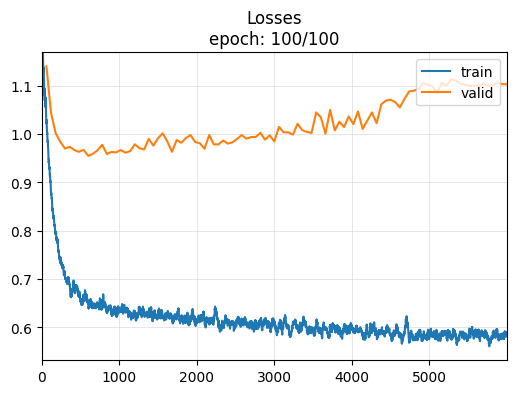

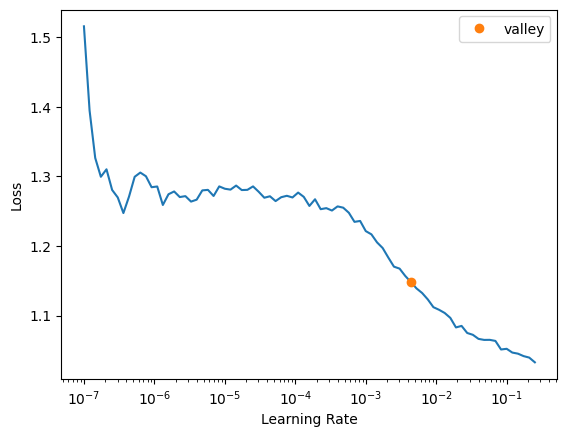

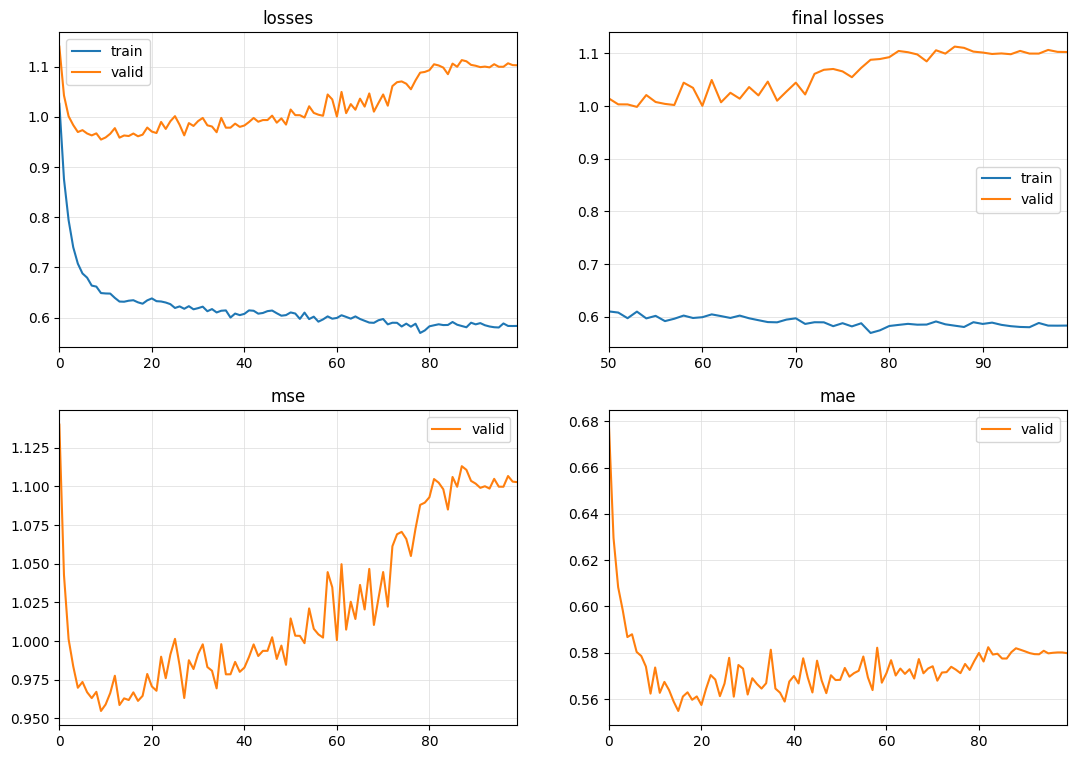

In [78]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 100
lr_max =learn.lr_find().valley
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

In [80]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(X[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")


scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df

scaled_preds.shape: (138, 39, 28)


,mse,mae
valid,1.102762,0.579812


In [82]:
learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (276, 39, 28)


,mse,mae
test,1.198121,0.461891


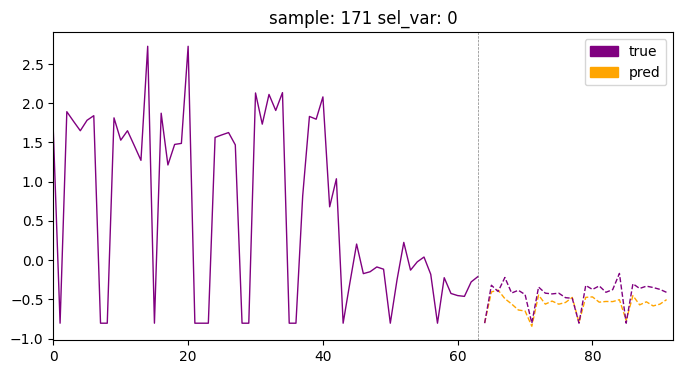

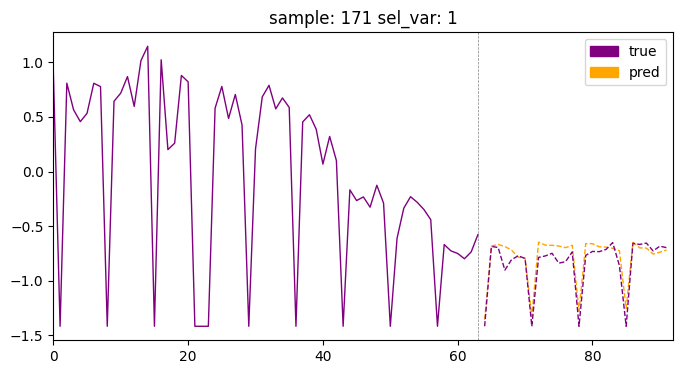

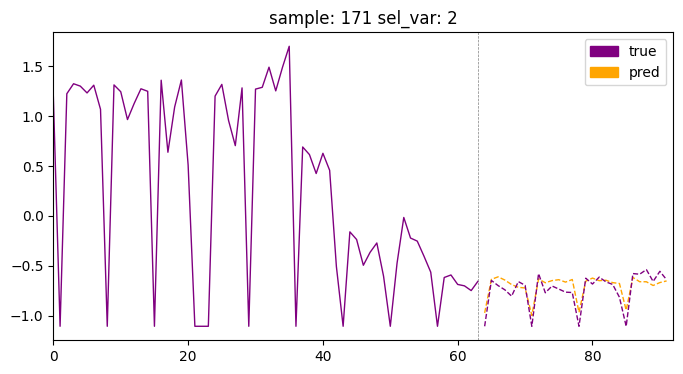

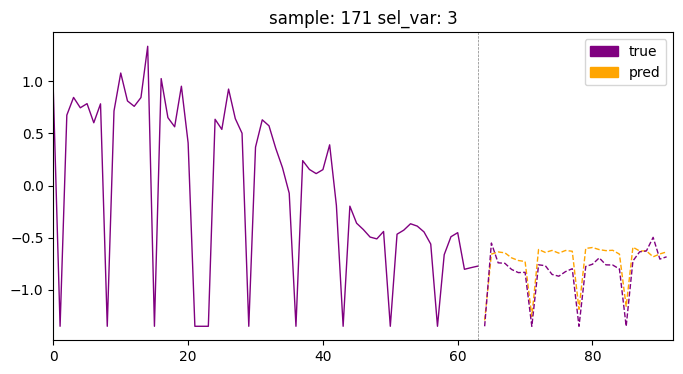

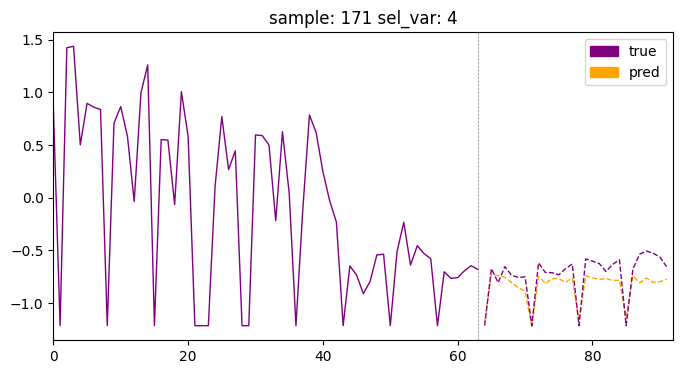

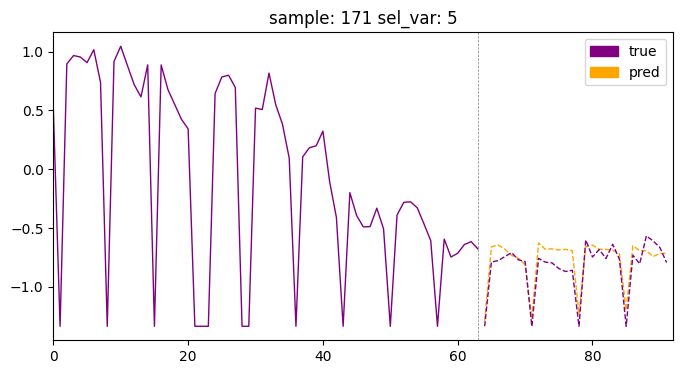

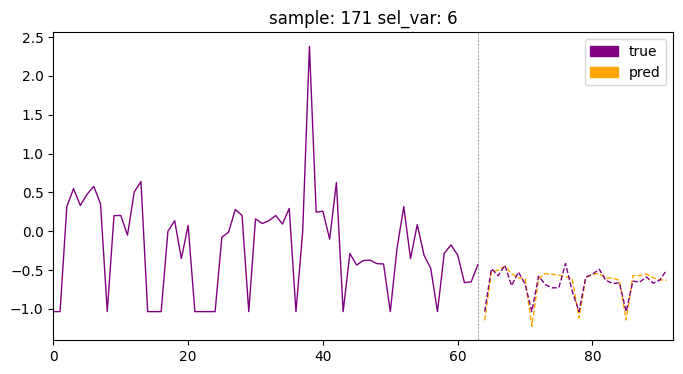

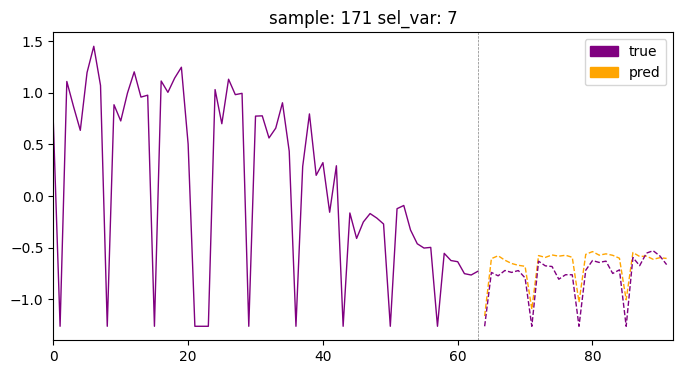

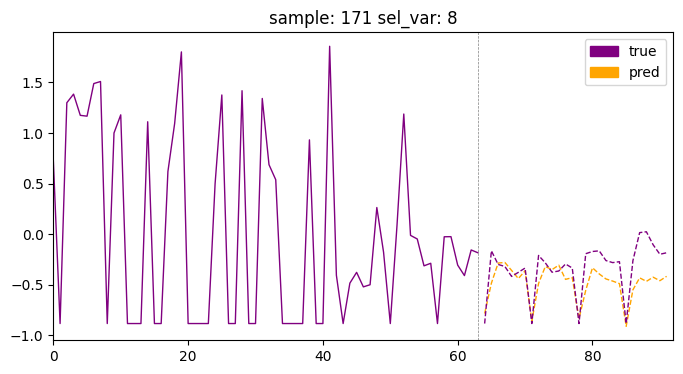

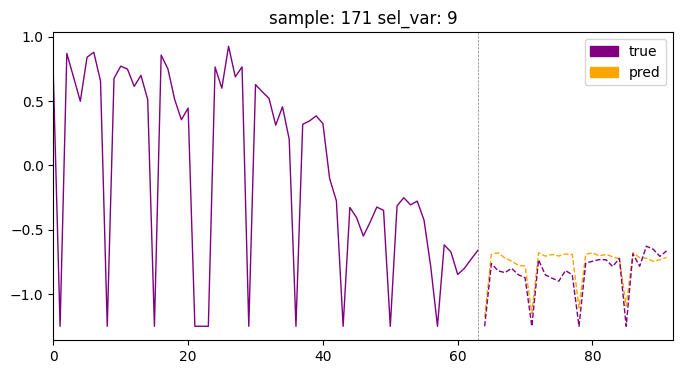

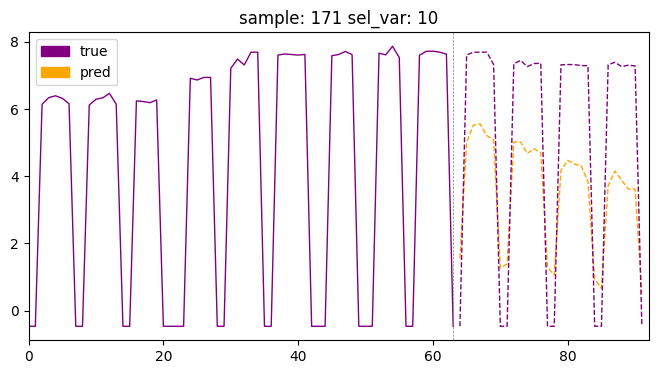

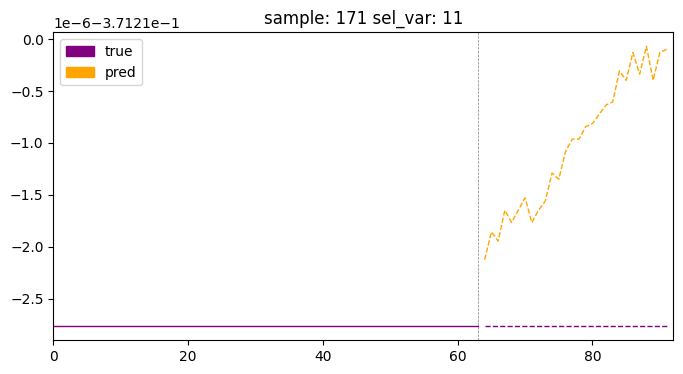

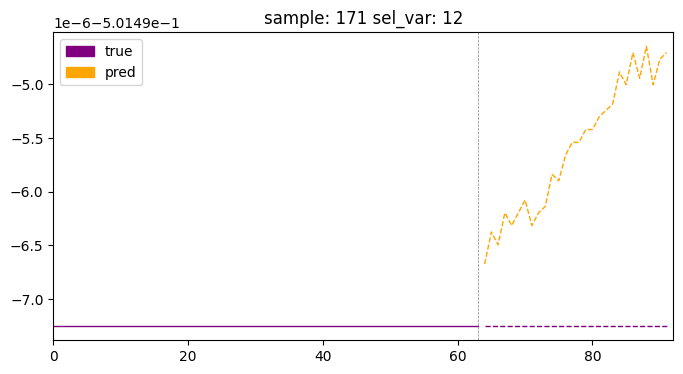

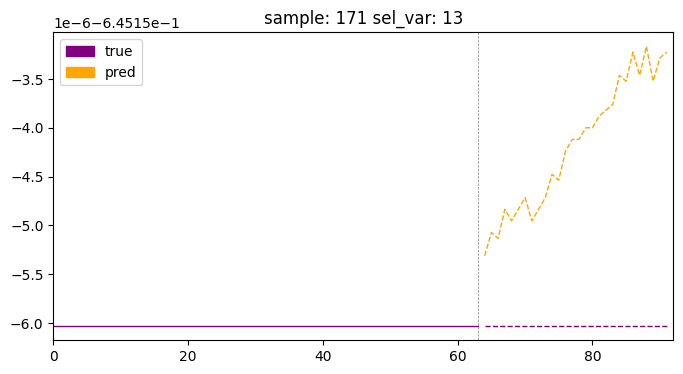

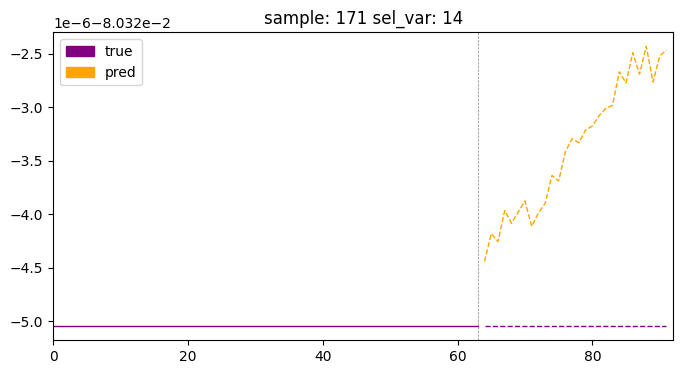

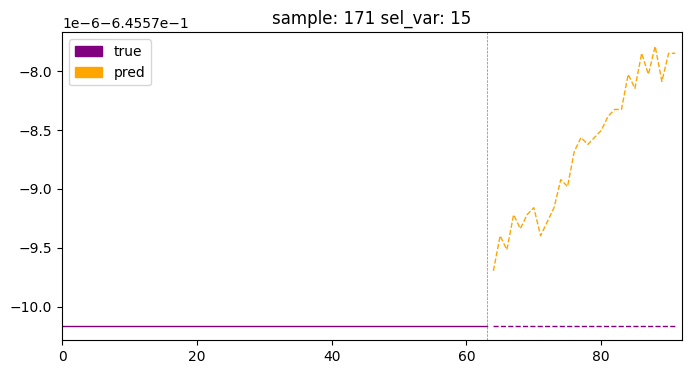

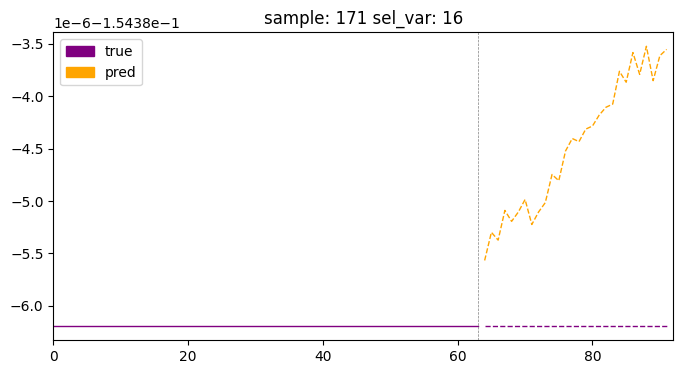

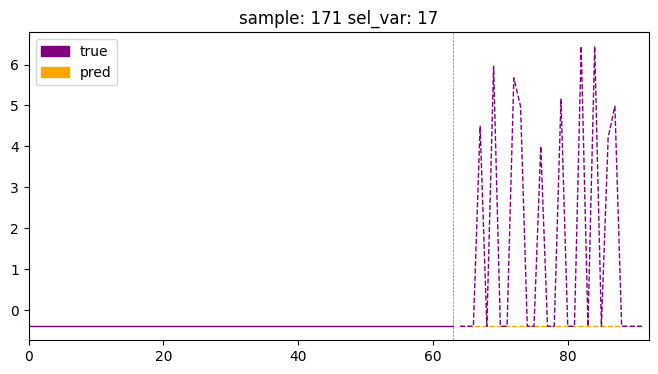

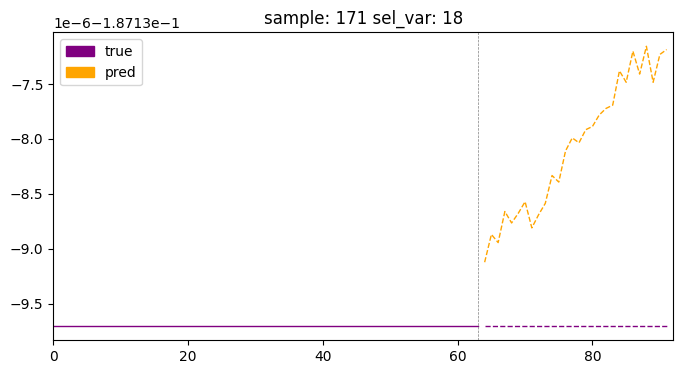

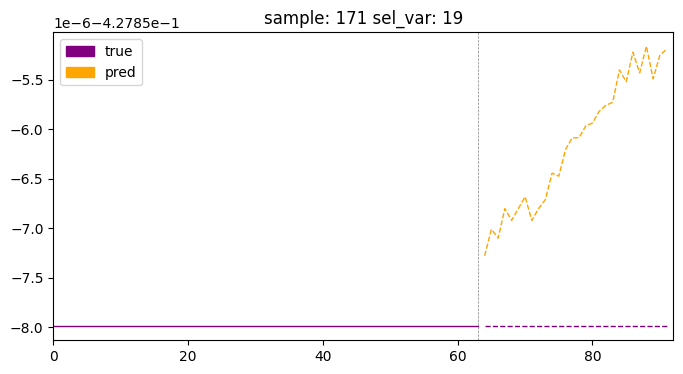

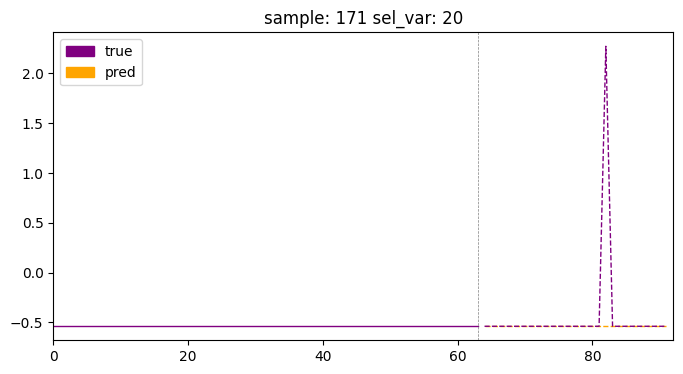

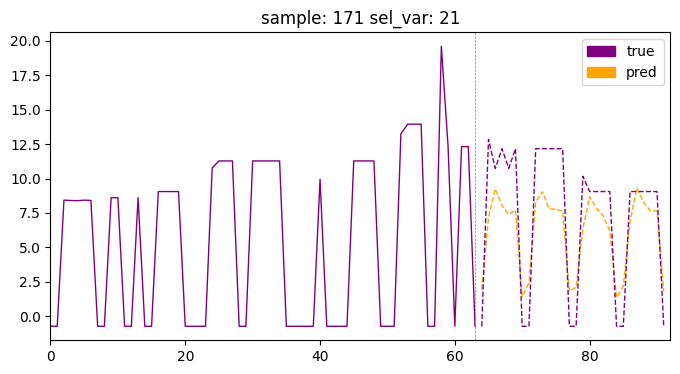

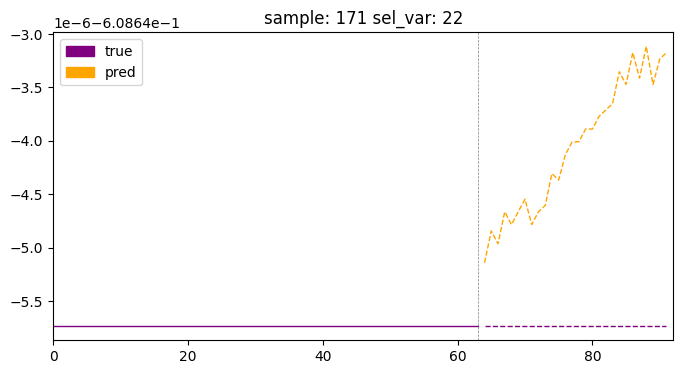

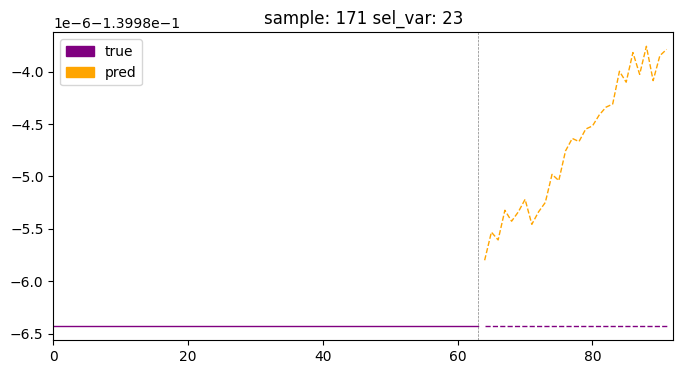

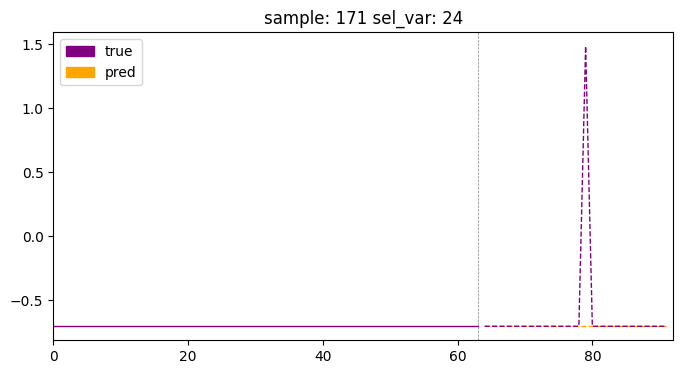

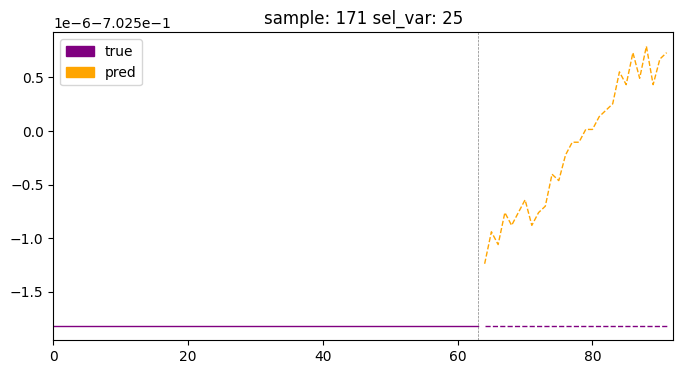

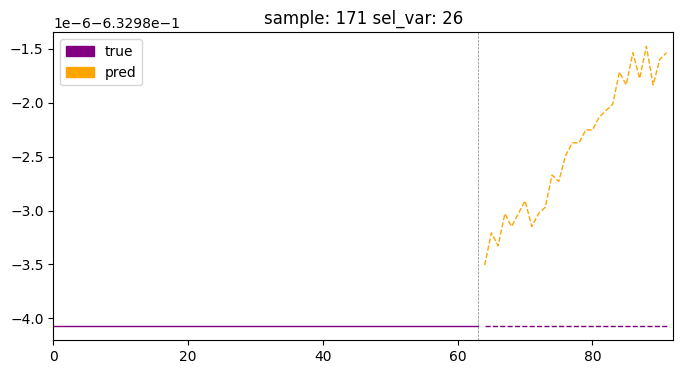

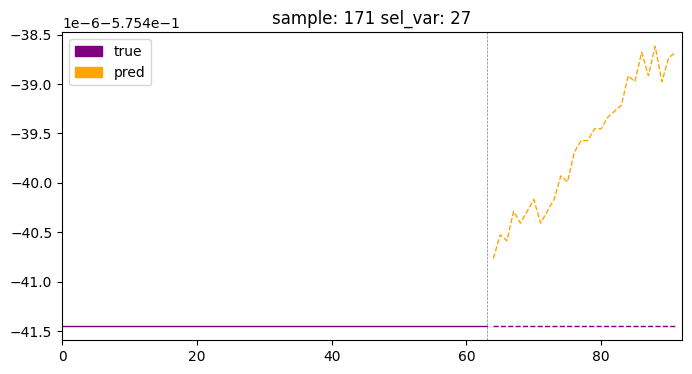

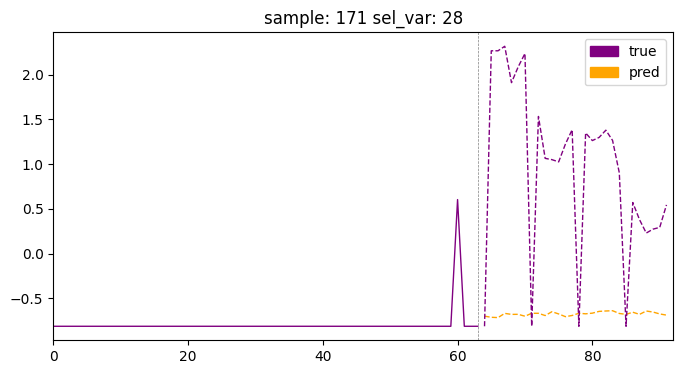

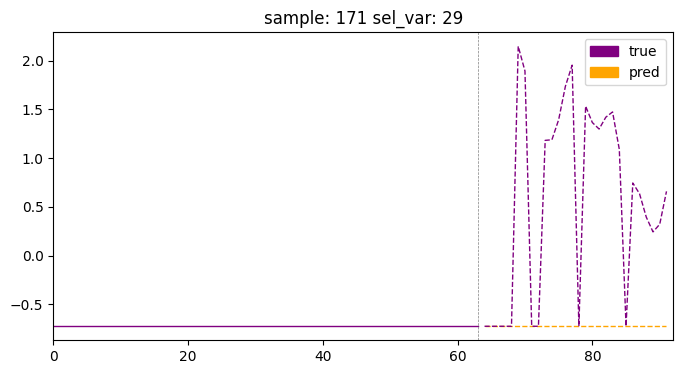

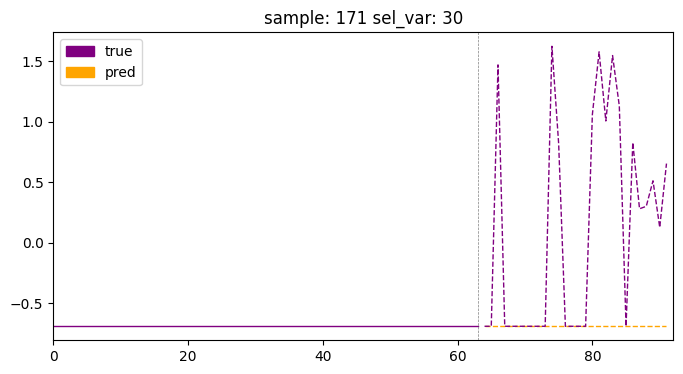

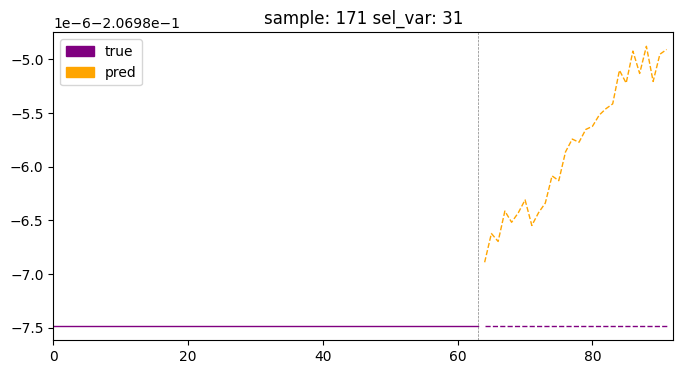

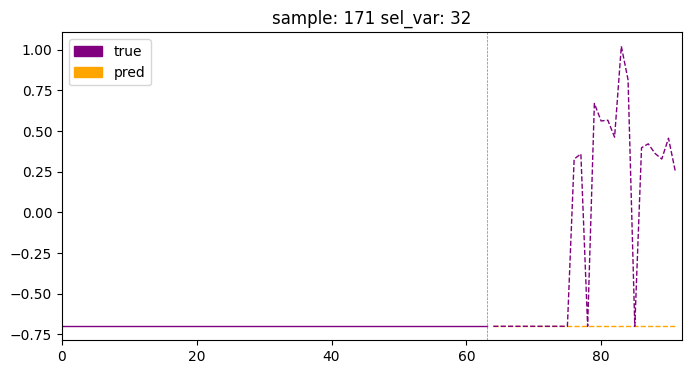

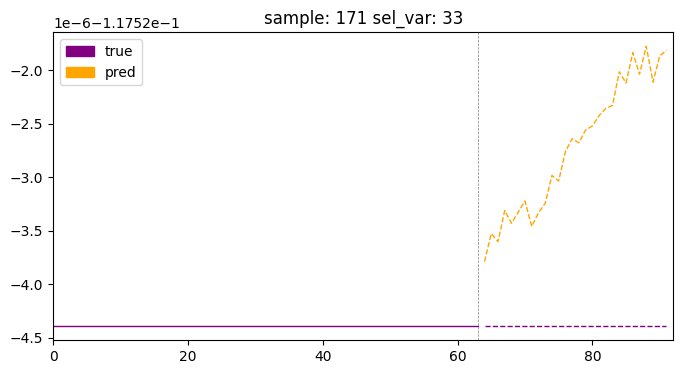

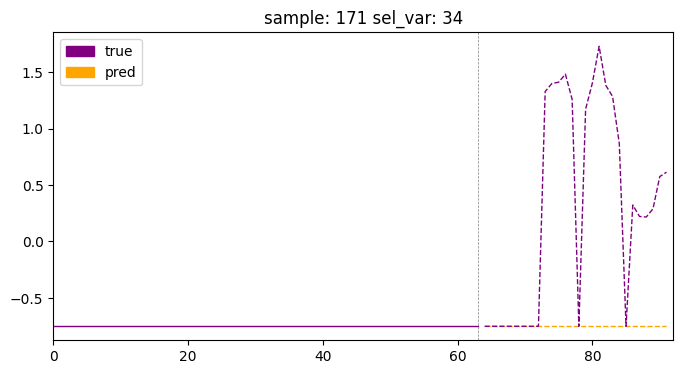

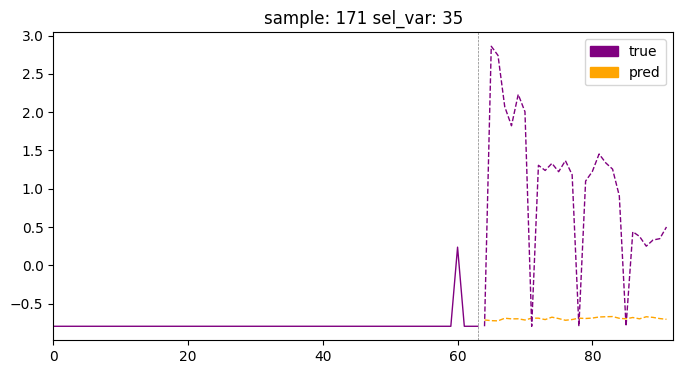

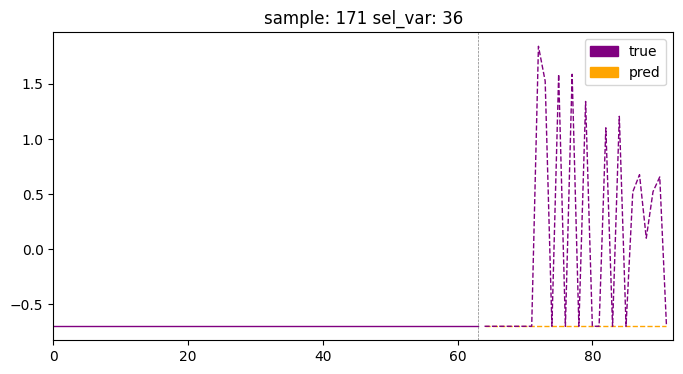

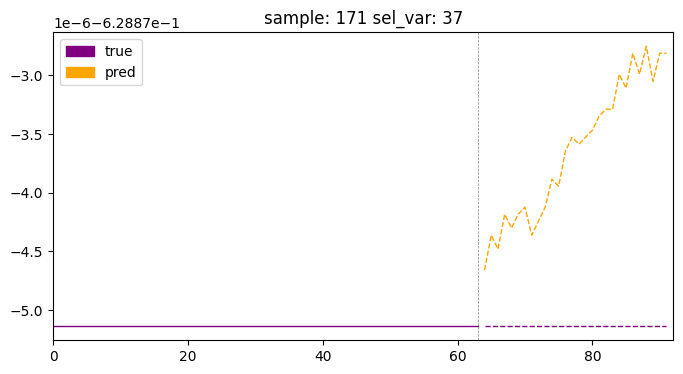

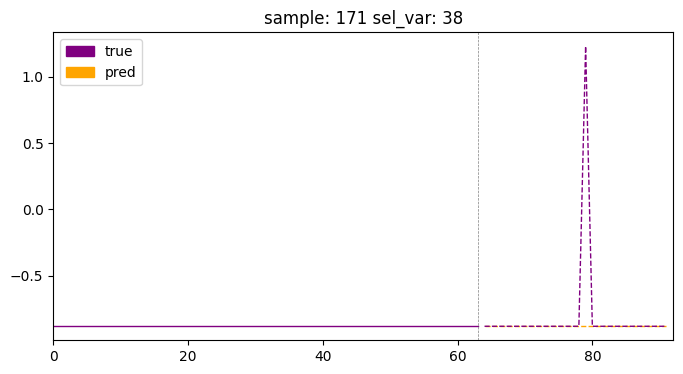

In [83]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

In [84]:
fcst_date = "2023-03-03"

dates = pd.date_range(start=None, end=fcst_date, periods=fcst_history, freq="1D")
dates

DatetimeIndex(['2022-12-30', '2022-12-31', '2023-01-01', '2023-01-02',
               '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-07', '2023-01-08', '2023-01-09', '2023-01-10',
               '2023-01-11', '2023-01-12', '2023-01-13', '2023-01-14',
               '2023-01-15', '2023-01-16', '2023-01-17', '2023-01-18',
               '2023-01-19', '2023-01-20', '2023-01-21', '2023-01-22',
               '2023-01-23', '2023-01-24', '2023-01-25', '2023-01-26',
               '2023-01-27', '2023-01-28', '2023-01-29', '2023-01-30',
               '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03',
               '2023-02-04', '2023-02-05', '2023-02-06', '2023-02-07',
               '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-11',
               '2023-02-12', '2023-02-13', '2023-02-14', '2023-02-15',
               '2023-02-16', '2023-02-17', '2023-02-18', '2023-02-19',
               '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23',
      

In [85]:
new_df= price_data_scaled.iloc[-64 :, :]
new_df.reset_index(drop= True , inplace = True)


In [86]:
new_df

,date,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,2022-12-30 00:00:00,-0.043733,-0.445961,-0.441035,-0.258778,-0.584008,-0.310811,-0.169418,-0.253961,0.030267,...,0.990179,1.307382,-0.206987,0.673668,-0.117524,0.923202,0.820544,1.337427,1.018427,1.207538
1,2022-12-31 00:00:00,-0.102334,-0.461822,-0.336604,-0.274280,-0.561870,-0.390469,-0.381495,-0.409250,-0.056801,...,0.969948,1.473542,-0.206987,-0.699660,-0.117524,0.954539,0.879652,1.333355,0.752580,0.940226
2,2023-01-01 00:00:00,-0.803776,-1.416846,-1.108016,-1.348725,-1.212835,-1.335983,-1.034458,-1.260163,-0.883367,...,-0.723722,-0.689007,-0.206987,-0.699660,-0.117524,-0.750614,-0.795080,-0.702507,-0.628875,-0.879549
3,2023-01-02 00:00:00,-0.803776,-1.416846,-1.108016,-1.348725,-1.212835,-1.335983,-1.034458,-1.260163,-0.883367,...,-0.723722,-0.689007,-0.206987,-0.699660,-0.117524,-0.750614,-0.795080,-0.702507,-0.628875,-0.879549
4,2023-01-03 00:00:00,-0.204709,-0.424566,-0.599981,-0.424138,-0.635289,-0.271538,-0.427940,-0.389044,-0.046445,...,2.036474,2.395648,-0.206987,2.010364,-0.117524,1.727069,1.655049,2.129378,0.496227,1.049893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2023-02-27 00:00:00,0.134187,0.119897,0.054521,0.263936,0.198663,0.212704,-1.034458,0.015458,0.121553,...,0.779655,1.457913,-0.206987,0.690115,-0.117524,0.934102,0.788765,0.985902,0.918734,0.724321
60,2023-02-28 00:00:00,0.580752,0.061984,-0.076511,0.170126,-0.472198,0.232711,-1.034458,-0.049278,-0.241675,...,1.310705,1.807507,-0.206987,1.448174,-0.117524,1.222268,1.416710,1.490795,0.966207,0.940226
61,2023-03-01 00:00:00,0.395418,0.122480,0.987833,0.255986,-0.164230,0.278283,-1.034458,0.472720,-0.883367,...,1.702671,2.044409,-0.206987,1.422756,-0.117524,1.624883,1.615644,1.887110,0.845152,1.087591
62,2023-03-02 00:00:00,0.324109,0.139448,0.060432,0.242869,-0.096695,0.318667,-1.034458,0.279263,-0.153074,...,1.215243,1.519606,-0.206987,0.847857,-0.117524,1.419147,1.203158,1.551193,0.921108,0.912810


In [88]:
x_feat = new_df.columns[1:]
new_X, _ = prepare_forecasting_data(new_df, fcst_history=fcst_history, fcst_horizon=0, x_vars=x_vars, y_vars=None)
new_X.shape

(1, 39, 64)

In [89]:
new_scaled_preds, *_ = learn.get_X_preds(new_X)

new_scaled_preds = to_np(new_scaled_preds).swapaxes(1,2).reshape(-1, len(y_vars))
dates = pd.date_range(start=fcst_date, periods=fcst_horizon + 1, freq='1D')[1:]
preds_df = pd.DataFrame(dates, columns=[datetime_col])
preds_df.loc[:, y_vars] = new_scaled_preds
preds_df = learn.inverse_transform(preds_df)
col_to_round = preds_df.columns[1:]
preds_df[col_to_round] = np.round(preds_df[col_to_round]).astype(int)
# preds_df= np.round(preds_df, 0).astype(int)
preds_df

,date,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,2023-03-04,3133,3788,3315,3779,4640,4263,497,3549,1347,...,2622,2426,45,2310,104,2470,2545,2714,595,430
1,2023-03-05,119,-59,-176,101,-48,-41,152,211,169,...,33,-34,65,26,43,224,20,115,-63,-135
2,2023-03-06,3092,3850,3291,3852,4472,4308,608,3575,1678,...,2827,2572,124,2387,113,2573,2623,2936,630,492
3,2023-03-07,3329,3944,3405,4021,4614,4623,654,3735,1447,...,2979,2805,136,2478,88,2712,2855,3048,673,541
4,2023-03-08,3285,4076,3669,4022,4533,4582,552,3813,1364,...,2951,2779,37,2473,-12,2798,2823,3047,681,551
5,2023-03-09,3379,4108,3638,4203,4605,4658,342,3869,1411,...,3030,2880,23,2541,58,2880,2951,3152,685,556
6,2023-03-10,3258,3940,3233,4109,4572,4600,648,3728,1310,...,2923,2770,52,2535,22,2878,2888,3031,655,534
7,2023-03-11,3040,3716,2843,3799,4200,4276,710,3465,1030,...,2800,2621,43,2287,82,2673,2674,2927,607,498
8,2023-03-12,280,211,-140,373,-127,282,68,418,-76,...,396,348,66,104,93,558,342,518,9,-27
9,2023-03-13,3254,4062,3058,4184,4415,4560,509,3930,1487,...,3204,2978,126,2485,105,3012,3005,3349,709,579


In [92]:
preds_df[0]

0     3133
1      119
2     3092
3     3329
4     3285
5     3379
6     3258
7     3040
8      280
9     3254
10    3495
11    3492
12    3415
13    3323
14    2916
15     396
16    3171
17    3208
18    3200
19    3163
20    3015
21    2661
22     173
23    2750
24    3062
25    3005
26    2807
27    2706
Name: 0, dtype: int64

In [91]:
submit = pd.read_csv('./../../DATA/sample_submission.csv')
submit.head(30)

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
5,TG_A_J_20230309,0
6,TG_A_J_20230310,0
7,TG_A_J_20230311,0
8,TG_A_J_20230312,0
9,TG_A_J_20230313,0


In [95]:
for i in range(39):
    submit.iloc[i*28 :(i+1)*28  , 1] = preds_df[i] 
# submit.iloc[0:28 , 1 ] = preds_df[0]

In [97]:
submit.loc[submit['answer'] <= 0, 'answer'] = 0
submit.loc[submit.index % 7 == 1, 'answer'] = 0

In [99]:
submit.to_csv('../../DATA/SUBMIT/patchTST.csv', index=False)